In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


train_path = 'kaggle_housing_data/train.csv'
test_path = 'kaggle_housing_data/test.csv'

df_test = pd.read_csv(test_path)
df_train = pd.read_csv(train_path)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Remove majority null or majority single value features

In [20]:
from src import utils
try:
    df_train.drop("Id", axis=1, inplace=True)
except:
    print("Id columns already removed.")

missing_pct_cols = utils.drop_null_majority_features(df_train, df_test)
# print(f"after:\n {df_train.describe()}")


Analyzing single-value dominant features:
  DROPPING Street: 99.6% are 'Pave'
  DROPPING Utilities: 99.9% are 'AllPub'
  DROPPING Condition2: 99.0% are 'Norm'
  DROPPING RoofMatl: 98.2% are 'CompShg'
  DROPPING Heating: 97.8% are 'GasA'


In [21]:
print(missing_pct_cols)

['LotFrontage', 'MasVnrType', 'FireplaceQu']


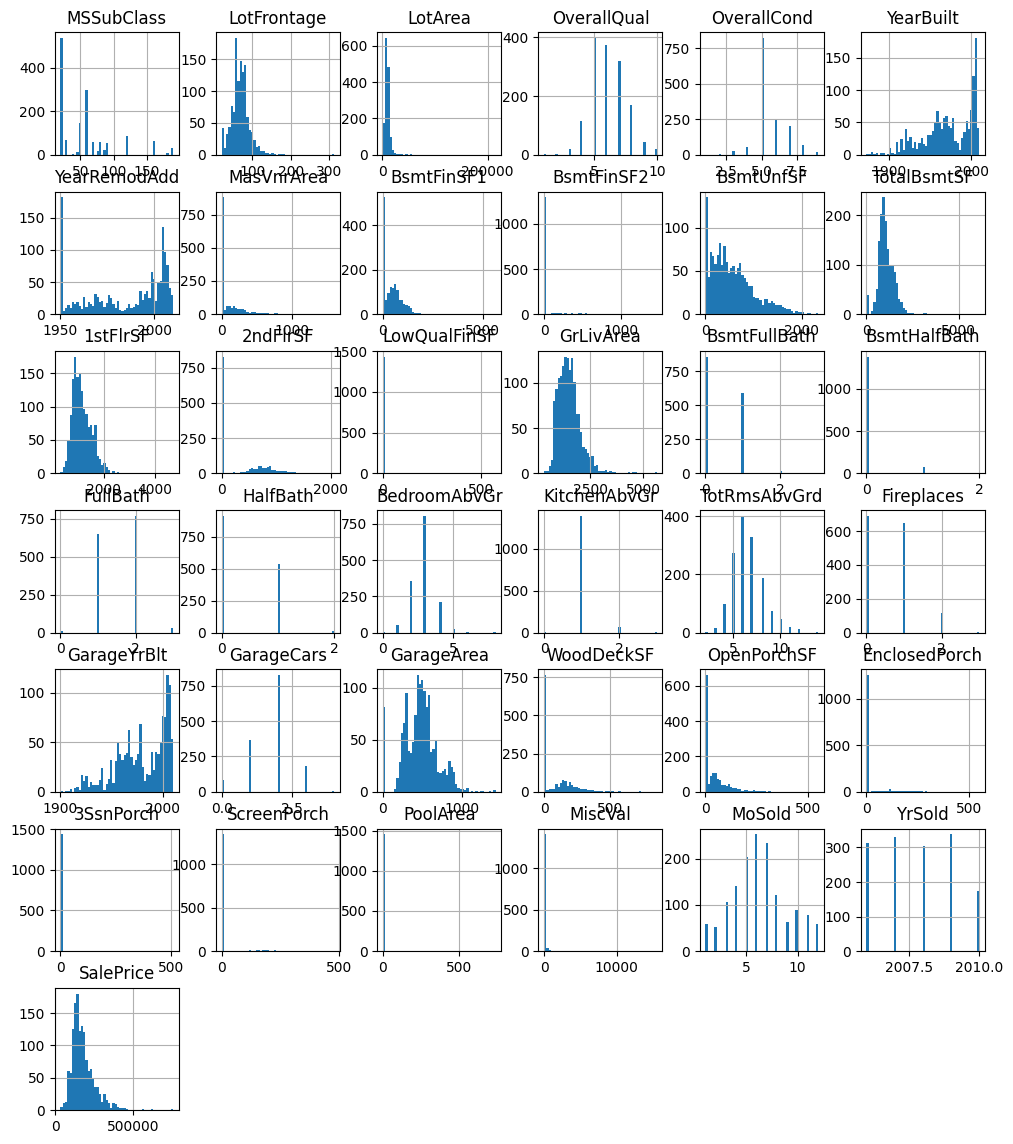

In [22]:

df_train.hist(bins=50, figsize=(12, 14))
plt.show()

In [23]:
corr_matrix = df_train.corr(numeric_only=True)
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


# Stratified split of the data based on overall quality of the house

In [24]:
strat_train_set, strat_test_set = train_test_split(
    df_train, test_size=0.2, stratify=df_train["OverallQual"],
    random_state=42
)

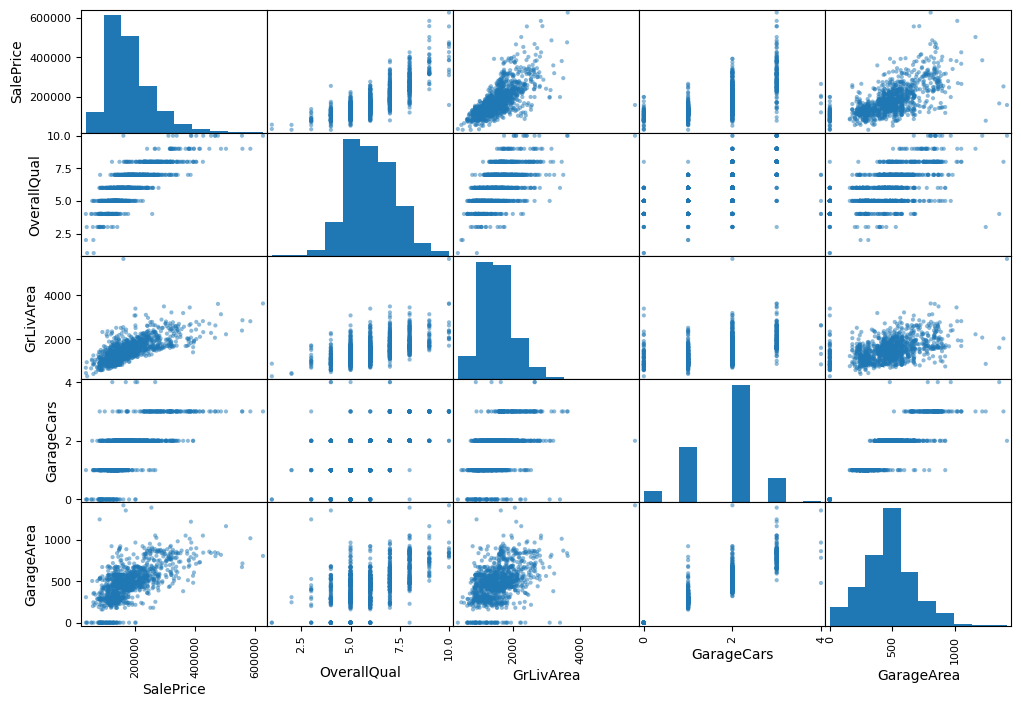

In [25]:

attributes = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars",
              "GarageArea"]

scatter_matrix(strat_train_set[attributes], figsize=(12, 8))
plt.show()

Lets try to make some new useful features

In [26]:
housing = strat_train_set.copy()

In [27]:
housing["1stFlrRatio"] = housing["1stFlrSF"] / housing["GrLivArea"]
housing["yrsSinceRemod"] = housing["YrSold"] - housing["YearRemodAdd"]
housing["bdrmRatio"] = housing["BedroomAbvGr"] / housing["TotRmsAbvGrd"]
housing["OvaAll"] = housing['OverallCond'] + housing['OverallQual']

In [28]:
corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.800531
GrLivArea        0.700908
GarageCars       0.651388
GarageArea       0.634647
TotalBsmtSF      0.604969
OvaAll           0.597406
1stFlrSF         0.596394
FullBath         0.563145
TotRmsAbvGrd     0.534714
YearBuilt        0.528381
YearRemodAdd     0.526142
GarageYrBlt      0.493869
Fireplaces       0.462406
MasVnrArea       0.461716
LotFrontage      0.353105
BsmtFinSF1       0.351111
OpenPorchSF      0.325071
WoodDeckSF       0.312707
2ndFlrSF         0.307961
HalfBath         0.290130
LotArea          0.275339
BsmtUnfSF        0.242704
BsmtFullBath     0.231159
BedroomAbvGr     0.175717
ScreenPorch      0.127168
MoSold           0.083639
3SsnPorch        0.056172
PoolArea         0.015600
BsmtFinSF2      -0.003980
YrSold          -0.005636
MiscVal         -0.024854
LowQualFinSF    -0.030394
BsmtHalfBath    -0.040339
OverallCond     -0.081920
MSSubClass      -0.087740
EnclosedPorch   -0.130961
KitchenAbvGr    -0.137589
1stFlrRatio 

Bedroom ratio and Days since remodelling seem like pretty good correlated features, lets plot them on a scatterplot

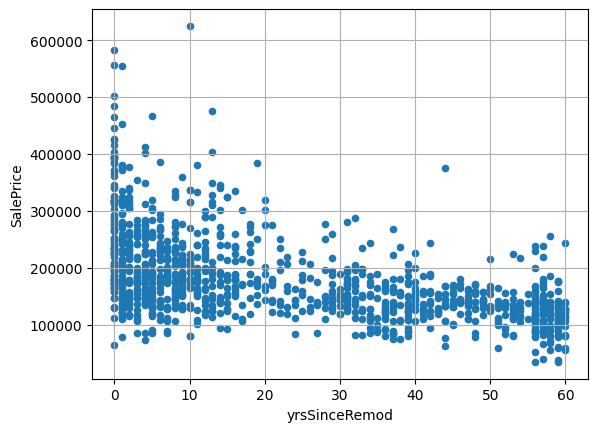

In [29]:
housing.plot(kind="scatter", x="yrsSinceRemod", y="SalePrice", grid=True)
plt.show()

# Creating the transformer pipeline

Custom transformer for negative skewed/ left tailed data

In [30]:
class LeftToRightSkewTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-6):
        self.epsilon = epsilon
        self.max_val = None
        
    def fit(self, X, y=None):
        self.max_val = np.max(X)
        return self
    
    def transform(self, X):
        if self.max_val is None:
            raise RuntimeError("LeftToRightSkewTransformer is not fitted. Call fit() first.")
        
        X_np = np.asarray(X)
        return self.max_val - X_np + self.epsilon
    
    def get_feature_names_out(self, names=None):
        return [f"{f}_reflected" for f in names]

In [31]:
class QualitySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        area_scaled = (X.iloc[:, 2] / 5000) * 10
        combo = X.iloc[:, 0] + X.iloc[:, 1] + area_scaled
        return combo.values.reshape(-1, 1)
    
    def get_feature_names_out(Self, input_features=None):
        return ['quality_size_combo']

In [32]:
# Ratio features
def column_ratio(X):
    return X[:, [0]] + 1e-6 / (X[:, [1]] + 1e-6)

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,
                            feature_names_out=ratio_name),
        StandardScaler()
    )

In [33]:
# Subtract features
def column_sub(X):
    return X[:, [0]] - X[:, [1]] + 1e-6

def sub_name(function_transformer, feature_names_in):
    return ["subtraction"]

def sub_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_sub,
                            feature_names_out=sub_name),
        StandardScaler()
    )

In [34]:
# Missing Percentage Features
def column_missing(X):
    return X.isnull().astype(int).values

def missing_name(function_transformer, feature_names_in):
    return ["missing_pct"]

def missing_pipeline():
    return make_pipeline(
        FunctionTransformer(column_missing,
                            feature_names_out=missing_name)
    )

In [35]:
right_skew_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log1p", FunctionTransformer(func=np.log1p,
                                    inverse_func=np.expm1,
                                    feature_names_out="one-to-one")),
        ("standard", StandardScaler())
    ]
)

left_skew_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("leftskew", LeftToRightSkewTransformer(epsilon=1e-6)),
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp, feature_names_out="one-to-one")),
        ("standard", StandardScaler())
    ]
)

default_num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("standard", StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

target_pipeline = Pipeline(
    steps=[
        ("log1p", FunctionTransformer(
            func=np.log1p,
            inverse_func=np.expm1,
            feature_names_out="one-to-one"
        )),
        ("standard", StandardScaler())
    ]
)

# -----Manual adding of features-----
df_train["BathAbvGr"] = df_train['FullBath'] + df_train['HalfBath']
df_train['RmsWBathRms'] = df_train['TotRmsAbvGrd'] + df_train['BathAbvGr']

df_test["BathAbvGr"] = df_test['FullBath'] + df_test['HalfBath']
df_test['RmsWBathRms'] = df_test['TotRmsAbvGrd'] + df_test['BathAbvGr']
# -----End of Manual adding-----

preprocessing = ColumnTransformer(
    [
        ("floor1_to_house_sf", ratio_pipeline(), ["1stFlrSF", "GrLivArea"]),
        ("last_remodel", sub_pipeline(), ["YrSold", "YearRemodAdd"]),
        ("bedroom_to_rooms", ratio_pipeline(), ["BedroomAbvGr", "TotRmsAbvGrd"]),
        ("bathroom_to_rooms", ratio_pipeline(), ["BathAbvGr", "RmsWBathRms"]),
        *[(f"{feature}", missing_pipeline(), [feature]) for feature in missing_pct_cols],
        ("overall_size_cond", QualitySizeTransformer(), ['OverallCond', 'OverallQual', 'GrLivArea']),
        ("right_skew", right_skew_pipeline, ["LotFrontage", "LotArea", "BsmtUnfSF",
                                             "TotalBsmtSF", "1stFlrSF", "GrLivArea"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=default_num_pipeline
)

In [36]:
housing = df_train.drop("SalePrice", axis=1)
housing_labels = df_train["SalePrice"].copy()

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared_dense = housing_prepared.toarray()
# housing_prepared_dense

df_housing_prepared = pd.DataFrame(
    housing_prepared_dense,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)
df_housing_prepared



,floor1_to_house_sf__ratio,last_remodel__subtraction,bedroom_to_rooms__ratio,bathroom_to_rooms__ratio,LotFrontage__missing_pct,MasVnrType__missing_pct,FireplaceQu__missing_pct,overall_size_cond__quality_size_combo,right_skew__LotFrontage,right_skew__LotArea,...,remainder__GarageCars,remainder__GarageArea,remainder__WoodDeckSF,remainder__OpenPorchSF,remainder__EnclosedPorch,remainder__3SsnPorch,remainder__ScreenPorch,remainder__PoolArea,remainder__MiscVal,remainder__MoSold
0,-0.793434,-0.869941,0.163779,1.323851,0.0,0.0,1.0,15.420,-0.078896,-0.133270,...,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111
1,0.257140,0.390141,0.163779,0.065503,0.0,1.0,0.0,16.524,0.572719,0.113413,...,0.311725,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110
2,-0.627826,-0.821476,0.163779,1.323851,0.0,0.0,0.0,15.572,0.062541,0.420049,...,0.311725,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891
3,-0.521734,0.632464,0.163779,-1.192845,0.0,1.0,0.0,15.434,-0.329561,0.103317,...,1.650307,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111
4,-0.045611,-0.724547,1.390023,1.323851,0.0,0.0,0.0,17.396,0.726089,0.878431,...,1.650307,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.542435,-0.773012,0.163779,1.323851,0.0,1.0,0.0,14.294,-0.226913,-0.259231,...,0.311725,-0.060731,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891
1456,2.355701,-0.046041,0.163779,0.065503,0.0,0.0,0.0,16.146,0.763303,0.725429,...,0.311725,0.126420,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111
1457,0.065656,-0.918406,1.390023,0.065503,0.0,1.0,0.0,20.680,-0.031048,-0.002359,...,-1.026858,-1.033914,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,-0.489110
1458,-0.218982,-0.433759,-1.062465,-1.192845,0.0,1.0,1.0,13.156,0.062541,0.136833,...,-1.026858,-1.090059,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110


# Testing different models for the job

Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = TransformedTargetRegressor(
    regressor=make_pipeline(preprocessing, LinearRegression()),
    transformer=target_pipeline
)

lin_reg_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)
pd.Series(lin_reg_rmses).describe()

count       10.000000
mean     28267.680849
std      10346.248026
min      17941.576165
25%      22679.637226
50%      24816.539950
75%      30980.867947
max      53561.742900
dtype: float64

Decision Trees

In [38]:
tree_reg = TransformedTargetRegressor(
    regressor=make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42)),
    transformer=target_pipeline
)
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10, n_jobs=-1)
pd.Series(tree_rmses).describe()

count       10.000000
mean     41395.321061
std       7804.203156
min      29700.201522
25%      36526.767794
50%      40042.373973
75%      43528.126229
max      55220.461846
dtype: float64

# Tuning random forest's hyper-parameters

Grid Search Cross Validation

In [42]:
from sklearn.decomposition import PCA

param_grid = {
    "regressor__xgboost_reg__n_estimators": randint(500, 1400),
    "regressor__xgboost_reg__max_depth": randint(3, 10),
    "regressor__xgboost_reg__learning_rate": [0.05, 0.075, 0.1, 0.15],
    "regressor__xgboost_reg__subsample": [0.85, 0.9, 0.95],
    "regressor__xgboost_reg__colsample_bytree": [0.8, 0.9, 1.0],
    "regressor__xgboost_reg__reg_alpha": [0, 0.1, 0.2],
    "regressor__xgboost_reg__reg_lambda": [1, 1.5, 2],
    "regressor__xgboost_reg__min_child_weight": [3, 5, 7],
    "regressor__pca__n_components": randint(10, 200)
}

xgboost_reg = TransformedTargetRegressor(
    regressor=Pipeline(
        steps=[
            ("preprocessing", preprocessing),
            ("pca", PCA()),
            ("xgboost_reg", xgb.XGBRegressor(random_state=42, n_jobs=-1)),
        ]),
    transformer=target_pipeline
)


randomized_search = RandomizedSearchCV(
    xgboost_reg,
    param_distributions=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42,
    n_iter=200
)
randomized_search.fit(housing, housing_labels)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END regressor__pca__n_components=47, regressor__xgboost_reg__colsample_bytree=0.9, regressor__xgboost_reg__learning_rate=0.15, regressor__xgboost_reg__max_depth=6, regressor__xgboost_reg__min_child_weight=3, regressor__xgboost_reg__n_estimators=660, regressor__xgboost_reg__reg_alpha=0.1, regressor__xgboost_reg__reg_lambda=1.5, regressor__xgboost_reg__subsample=0.85; total time=   5.8s
[CV] END regressor__pca__n_components=47, regressor__xgboost_reg__colsample_bytree=0.9, regressor__xgboost_reg__learning_rate=0.15, regressor__xgboost_reg__max_depth=6, regressor__xgboost_reg__min_child_weight=3, regressor__xgboost_reg__n_estimators=660, regressor__xgboost_reg__reg_alpha=0.1, regressor__xgboost_reg__reg_lambda=1.5, regressor__xgboost_reg__subsample=0.85; total time=   6.6s
[CV] END regressor__pca__n_components=84, regressor__xgboost_reg__colsample_bytree=1.0, regressor__xgboost_reg__learning_rate=0.15, regressor__xgboost

,estimator,TransformedTa...rdScaler())]))
,param_distributions,"{'regressor__pca__n_components': <scipy.stats....x7fc1a0fbf8f0>, 'regressor__xgboost_reg__colsample_bytree': [0.8, 0.9, ...], 'regressor__xgboost_reg__learning_rate': [0.05, 0.075, ...], 'regressor__xgboost_reg__max_depth': <scipy.stats....x7fc1a07cfec0>, ...}"
,n_iter,200
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [46]:
randomized_search.best_params_

{'regressor__pca__n_components': 130,
 'regressor__xgboost_reg__colsample_bytree': 1.0,
 'regressor__xgboost_reg__learning_rate': 0.075,
 'regressor__xgboost_reg__max_depth': 3,
 'regressor__xgboost_reg__min_child_weight': 3,
 'regressor__xgboost_reg__n_estimators': 1244,
 'regressor__xgboost_reg__reg_alpha': 0.2,
 'regressor__xgboost_reg__reg_lambda': 2,
 'regressor__xgboost_reg__subsample': 0.9}

Save tuned parameters in JSON format

In [47]:
import json

best_params = randomized_search.best_params_
with open('best_xgboost_regressor_params.txt', 'w') as f:
    json.dump(best_params, f, indent=4)

In [45]:
cv_res = pd.DataFrame(randomized_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False,
                   inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__pca__n_components,param_regressor__xgboost_reg__colsample_bytree,param_regressor__xgboost_reg__learning_rate,param_regressor__xgboost_reg__max_depth,param_regressor__xgboost_reg__min_child_weight,param_regressor__xgboost_reg__n_estimators,...,param_regressor__xgboost_reg__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,13.333429,0.709171,0.063724,0.008564,130,1.0,0.075,3,3,1244,...,0.90,"{'regressor__pca__n_components': 130, 'regress...",-23191.970703,-26365.802734,-33047.300781,-20623.583984,-35146.542969,-27675.040234,5589.625873,1
147,17.139534,2.049842,0.066264,0.006104,163,0.9,0.050,3,7,1348,...,0.90,"{'regressor__pca__n_components': 163, 'regress...",-23643.181641,-26126.277344,-32835.164062,-19956.853516,-36030.535156,-27718.402344,5910.274586,2
59,10.470769,0.577689,0.064816,0.008001,156,0.9,0.150,3,3,1015,...,0.85,"{'regressor__pca__n_components': 156, 'regress...",-25404.250000,-25517.083984,-34808.277344,-19853.373047,-33200.734375,-27756.743750,5520.411780,3
89,9.560352,1.270849,0.070458,0.018944,95,1.0,0.100,3,3,1109,...,0.95,"{'regressor__pca__n_components': 95, 'regresso...",-25038.494141,-28677.681641,-32092.746094,-19762.328125,-33313.996094,-27777.049219,4936.184703,4
125,16.037442,0.811792,0.058463,0.004239,171,1.0,0.100,3,5,1071,...,0.85,"{'regressor__pca__n_components': 171, 'regress...",-23810.150391,-27626.197266,-33945.320312,-19642.683594,-34497.773438,-27904.425000,5745.633579,5


# Using tuned hyper-params for quick evaluation

In [48]:
# final_model = TransformedTargetRegressor(
#     regressor=Pipeline(
#         steps=[
#             ("preprocessing", preprocessing),
#             ("random_forest", xgb.XGBRegressor(random_state=42, n_jobs=-1,
#                                                     n_estimators=1000, min_child_weight=7,
#                                                     subsample=0.95, reg_lambda=1, reg_alpha=0,
#                                                     max_depth=6, learning_rate=0.15, 
#                                                     colsample_bytree=1.0)),
#         ]),
#     transformer=target_pipeline
# )

final_model = randomized_search.best_estimator_

forest_reg_rmses = -cross_val_score(
    final_model, housing, housing_labels,
    scoring="neg_root_mean_squared_log_error",
    cv=5, n_jobs=-1
)

pd.Series(forest_reg_rmses).describe()

count    5.000000
mean     0.127576
std      0.010594
min      0.114897
25%      0.117237
50%      0.133862
75%      0.134993
max      0.136891
dtype: float64

In [49]:
final_model.fit(housing, housing_labels)

,regressor,"Pipeline(step...=None, ...))])"
,transformer,Pipeline(step...ardScaler())])
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('floor1_to_house_sf', ...), ('last_remodel', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


Make final predictions for submission

In [50]:
# final_model = randomized_search.best_estimator_
# df_test = pd.read_csv(test_path)
test_ids = df_test["Id"]

test_features = df_test.drop("Id", axis=1)
predictions = final_model.predict(test_features)
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})

submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

In [51]:
feature_names = final_model.regressor_.named_steps['preprocessing'].get_feature_names_out()
feature_importances = final_model.regressor_.named_steps['xgboost_reg'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(importance_df)

ValueError: All arrays must be of the same length

# Predictions with important features

In [ ]:
raise Exception("Stopping execution here")
threshold = 0.001
top_features = importance_df[importance_df['importance'] >= threshold]['feature'].tolist()
top_features

In [ ]:
with open('top_features.txt', 'w') as f:
    for feature in top_features:
        f.write(f"{feature}\n")

In [ ]:
class FeatureIndexSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_feature_names, all_feature_names):
        self.selected_feature_names = selected_feature_names
        self.all_feature_names = all_feature_names
        # Find indices of selected features
        self.selected_indices = [
            list(all_feature_names).index(name) 
            for name in selected_feature_names 
            if name in all_feature_names
        ]
        print(f"Selected {len(self.selected_indices)} features out of {len(all_feature_names)} total features")
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[:, self.selected_indices]
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.selected_feature_names)

with open('top_features.txt', 'r') as f:
    selected_features = [line.strip() for line in f.readlines()]

all_feature_names = final_model.regressor_.named_steps['preprocessing'].get_feature_names_out()

feature_selector = FeatureIndexSelector(selected_features, all_feature_names)

new_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", feature_selector),
    ("random_forest", RandomForestRegressor(random_state=42, n_jobs=-1,
                                            n_estimators=1400,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            max_features=60))
])

forest_reg_selected = TransformedTargetRegressor(
    regressor=new_pipeline,
    transformer=target_pipeline
)

Selected 51 features out of 250 total features


In [ ]:
new_model = TransformedTargetRegressor(
    regressor=new_pipeline,
    transformer=target_pipeline
)

new_model.fit(housing, housing_labels)

Selected 51 features out of 250 total features


,regressor,Pipeline(step...m_state=42))])
,transformer,Pipeline(step...ardScaler())])
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('floor1_to_house_sf', ...), ('last_remodel', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [ ]:
predictions = new_model.predict(test_features)
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})

submission_file_path = 'submission2.csv'
submission_df.to_csv(submission_file_path, index=False)